In [0]:
import torch
import torchvision
from torch.autograd import Variable
from torch.utils.data import TensorDataset,DataLoader
from torchvision import models, transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

import time
import os

In [0]:
trainPath ='/content/drive/My Drive/IC03 Dataset/training/'
testPath = '/content/drive/My Drive/IC03 Dataset/testing/'

In [0]:
%cd /content/drive/My Drive/IC03 Dataset

/content/drive/My Drive/IC03 Dataset


(1200, 1600, 3)
(1200, 1600)
(1200, 1600)


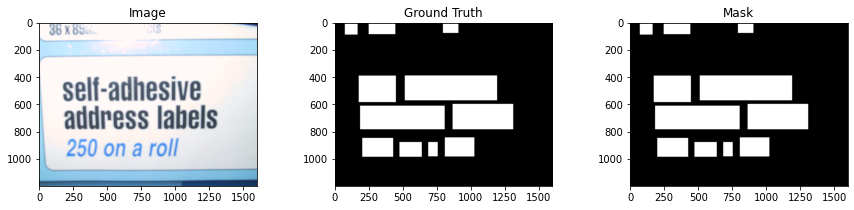

In [0]:
# Displaying sample image, groundtruth and mask from the dataset
sampleImg = np.array(Image.open(trainPath+'images/apanar_06.08.2002_IMG_1261.JPG'))
sampleGT = np.array(Image.open(trainPath+'gt/apanar_06.08.2002_IMG_1261.JPG'))
sampleMask = np.array(Image.open(trainPath+'gt/apanar_06.08.2002_IMG_1261.JPG'))
plt.figure(figsize=(15,3))
plt.subplot(131)
plt.imshow(sampleImg)
print(sampleImg.shape)
plt.title('Image')
plt.subplot(132)
sampleGT_1=np.zeros(shape=(sampleGT.shape[0],sampleGT.shape[1]))
sampleGT_1=sampleGT[:,:,0]

plt.imshow(sampleGT_1,cmap='gray')
plt.title('Ground Truth')
print(sampleGT_1.shape)
plt.subplot(133)
sampleMask_1=np.zeros(shape=(sampleMask.shape[0],sampleMask.shape[1]))
sampleMask_1=sampleMask[:,:,0]
plt.imshow(sampleMask_1,cmap='gray')
plt.title('Mask')
print(sampleMask_1.shape)

In [0]:
# DRIVE dataset has 20 images for training and 20 for testing
TrainImages = torch.FloatTensor(6750,3,224,224) # 20 images x 30 patches
TrainLabels = torch.FloatTensor(6750,224,224)
TestImages = torch.FloatTensor(25,3,224,224)
TestLabels = torch.FloatTensor(25,224,224)

# Obtain list containing name of all files in the directoy
trainImgList = os.listdir(trainPath+'images')
testImgList = os.listdir(testPath+'images')


In [0]:
# Preparing train data tensors
img_no = 0
for file in trainImgList:
    #imgNum = file.split('_')[0] # Image number from the filename
    im = np.array(Image.open(trainPath+'images/'+ file))
    seg = np.array(Image.open(trainPath+'gt/'+file))
    mask = np.array(Image.open(trainPath+'gt/'+file))
    seg_1=np.zeros(shape=(seg.shape[0],seg.shape[1]))
    seg_1=seg[:,:,0]
    seg_1 = seg_1/255
    mask = np.array(Image.open(trainPath+'gt/'+file))
    #im = np.array(im)
    
    mask_1=np.zeros(shape=(mask.shape[0],mask.shape[1]))
    mask_1=mask[:,:,0]
    mask_1 = mask_1/255
    idx = np.where(mask_1==1)
    # Note: In the GT (seg), 0--> BG, 1--> Vessels, 2--> Tissue(mask)
    mask_1[idx] = 2
    #print(file)
    #print(im.shape[0])
    # Augmenting training data by taking 30 patches, each of size 224x224, from the original image
    randIdx1 = np.random.randint(0,im.shape[0]-224,30) 
    randIdx2 = np.random.randint(0,im.shape[1]-224,30)
    for p in range(30):
        patch = im[randIdx1[p]:randIdx1[p]+224,randIdx2[p]:randIdx2[p]+224]/255
        seg_patch = mask_1[randIdx1[p]:randIdx1[p]+224,randIdx2[p]:randIdx2[p]+224]
      
        TrainImages[img_no] = torch.from_numpy(patch).transpose(0,2).unsqueeze(0)
        TrainLabels[img_no] = torch.from_numpy(seg_patch).transpose(0,1).unsqueeze(0)
        img_no += 1

In [0]:
# Preparing test data tensors
img_no = 0
for file in testImgList:
    #imgNum = file.split('_')[0] # Image number from the filename
    im = Image.open(testPath+'images/'+ file)
    seg = Image.open(testPath+'gt/'+ file)

    mask = Image.open(testPath+'gt/'+ file)
    # Resizing the images to 224x224
    im = np.array(im.resize((224,224)))/255
    seg = np.array(seg.resize((224,224)))
    seg_1=np.zeros(shape=(seg.shape[0],seg.shape[1]))
    seg_1=seg[:,:,0]
    seg_1 = seg_1/255
    mask = np.array(mask.resize((224,224)))
    mask_1=np.zeros(shape=(mask.shape[0],mask.shape[1]))
    mask_1=mask[:,:,0]
    mask_1 = mask_1/255    
    idx = np.where(mask_1==1)
    # Note: In the GT (seg), 0--> BG, 1--> Vessels, 2--> Tissue(mask)
    mask_1[idx] = 2
    TestImages[img_no] = torch.from_numpy(im).transpose(0,2).unsqueeze(0)
    TestLabels[img_no] = torch.from_numpy(mask_1).transpose(0,1).unsqueeze(0)
    img_no += 1

In [0]:
print(TrainImages.size())
print(TrainLabels.size())
print(TestImages.size())
print(TestLabels.size())

torch.Size([6750, 3, 224, 224])
torch.Size([6750, 224, 224])
torch.Size([25, 3, 224, 224])
torch.Size([25, 224, 224])


In [0]:
# Creating pytorch dataset
trainDataset = TensorDataset(TrainImages, TrainLabels)
testDataset = TensorDataset(TestImages, TestLabels)
# Creating dataloader
BatchSize = 2
trainLoader = DataLoader(trainDataset, batch_size=BatchSize, shuffle=True,num_workers=4, pin_memory=True)
testLoader = DataLoader(testDataset, batch_size=BatchSize, shuffle=False,num_workers=4, pin_memory=True)

In [0]:
# Check availability of GPU
use_gpu = torch.cuda.is_available()
if use_gpu:
    print('GPU is available!')

GPU is available!


In [0]:
import torch
import torch.nn as nn

def double_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True)
    )   


class UNet(nn.Module):

    def __init__(self, n_class):
        super().__init__()
                
        self.dconv_down1 = double_conv(3, 64)
        self.dconv_down2 = double_conv(64, 128)
        self.dconv_down3 = double_conv(128, 256)
        self.dconv_down4 = double_conv(256, 512)        

        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)        
        
        self.dconv_up3 = double_conv(256 + 512, 256)
        self.dconv_up2 = double_conv(128 + 256, 128)
        self.dconv_up1 = double_conv(128 + 64, 64)
        
        self.conv_last = nn.Conv2d(64, n_class, 1)
        
        
    def forward(self, x):
        conv1 = self.dconv_down1(x)
        x = self.maxpool(conv1)

        conv2 = self.dconv_down2(x)
        x = self.maxpool(conv2)
        
        conv3 = self.dconv_down3(x)
        x = self.maxpool(conv3)   
        
        x = self.dconv_down4(x)
        
        x = self.upsample(x)        
        x = torch.cat([x, conv3], dim=1)
        
        x = self.dconv_up3(x)
        x = self.upsample(x)        
        x = torch.cat([x, conv2], dim=1)       

        x = self.dconv_up2(x)
        x = self.upsample(x)        
        x = torch.cat([x, conv1], dim=1)   
        
        x = self.dconv_up1(x)
        
        out = self.conv_last(x)
        
        return out

In [0]:
from torchsummary import summary

net = UNet(6)
if use_gpu:
    net = net.cuda()
summary(net, (3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

In [0]:
criterion = nn.NLLLoss2d() # 2D Negative Log-Likelihood
optimizer = optim.Adam(net.parameters(), lr=1e-4)

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:210: UserWarning: NLLLoss2d has been deprecated. Please use NLLLoss instead as a drop-in replacement and see https://pytorch.org/docs/master/nn.html#torch.nn.NLLLoss for more details.
  warnings.warn("NLLLoss2d has been deprecated. "


In [0]:
iterations = 100
trainLoss = []
testLoss = []
start = time.time()

for epoch in range(iterations):
    epochStart = time.time()
    runningLoss = 0   
    net.train(True) # For training
    for data in trainLoader:
        inputs,labels = data
        # Wrap them in Variable
        if use_gpu:
            inputs, labels = Variable(inputs.cuda()), \
                Variable(labels.long().cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels.long())      
 
        
        # Feed-forward input data through the network
        outputs = net(inputs)
        # Compute loss/error
        loss = criterion(F.log_softmax(outputs), labels)      
        # Initialize gradients to zero
        optimizer.zero_grad()                  
        # Backpropagate loss and compute gradients
        loss.backward()
        # Update the network parameters
        optimizer.step()
        # Accumulate loss per batch
        runningLoss += loss.data          
    avgTrainLoss = runningLoss/600.0    
    trainLoss.append(avgTrainLoss)
    torch.save(net.state_dict(), 'INTERRUPTED.pth')
    #checkpointer = ModelCheckpoint('model-dsbowl2018-1.h5', verbose=1, save_best_only=True)
    # Evaluating performance on test set for each epoch
    net.train(False) # For testing
    net.eval()
    test_runningLoss = 0
    with torch.no_grad():    
      for data in testLoader:
          inputs_1,labels_1 = data
          # Wrap them in Variable
          if use_gpu:
              inputs_1, labels_1 = Variable(inputs_1.cuda()), \
                  Variable(labels_1.long().cuda())
          else:
              inputs_1, labels_1 = Variable(inputs_1), Variable(labels_1.long())         
          outputs_1 = net(inputs_1)       
          # Compute loss/error
          loss = criterion(F.log_softmax(outputs_1), labels_1)      
          # Accumulate loss per batch
          test_runningLoss += loss.data 
        
    avgTestLoss = test_runningLoss/20.0    
    testLoss.append(avgTestLoss)
        
    # Plotting Loss vs Epochs
    fig1 = plt.figure(1)        
    plt.plot(range(epoch+1),trainLoss,'r--',label='train')        
    plt.plot(range(epoch+1),testLoss,'g--',label='test')        
    if epoch==0:
        plt.legend(loc='upper left')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')   
      
    
    epochEnd = time.time()-epochStart
    print('At Iteration: {:.0f} /{:.0f}  ;  Training Loss: {:.6f}; Time consumed: {:.0f}m {:.0f}s '\
          .format(epoch + 1,iterations,avgTrainLoss,epochEnd//60,epochEnd%60))
    print('At Iteration: {:.0f} /{:.0f}  ;  Testing Loss: {:.6f} ; Time consumed: {:.0f}m {:.0f}s '\
          .format(epoch + 1,iterations,avgTestLoss,epochEnd//60,epochEnd%60))
    
    #predicted_classes = torch.argmax(labels_1, dim=1) == 2
    #target_classes = self.get_vector(labels)
    #target_true += torch.sum(target_classes == 2).float()
    #predicted_true += torch.sum(predicted_classes).float()
    #correct_true += torch.sum(
      #predicted_classes == target_classes * predicted_classes == 2).float()
end = time.time()-start
print('Training completed in {:.0f}m {:.0f}s'.format(end//60,end%60))


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:49: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


At Iteration: 1 /100  ;  Training Loss: 2.721424; Time consumed: 2m 45s 
At Iteration: 1 /100  ;  Testing Loss: 0.320691 ; Time consumed: 2m 45s 
At Iteration: 2 /100  ;  Training Loss: 1.844136; Time consumed: 2m 41s 
At Iteration: 2 /100  ;  Testing Loss: 0.275444 ; Time consumed: 2m 41s 
At Iteration: 3 /100  ;  Training Loss: 1.538249; Time consumed: 2m 41s 
At Iteration: 3 /100  ;  Testing Loss: 0.235715 ; Time consumed: 2m 41s 
At Iteration: 4 /100  ;  Training Loss: 1.281476; Time consumed: 2m 41s 
At Iteration: 4 /100  ;  Testing Loss: 0.313020 ; Time consumed: 2m 41s 
At Iteration: 5 /100  ;  Training Loss: 1.066556; Time consumed: 2m 41s 
At Iteration: 5 /100  ;  Testing Loss: 0.277375 ; Time consumed: 2m 41s 
At Iteration: 6 /100  ;  Training Loss: 0.917585; Time consumed: 2m 41s 
At Iteration: 6 /100  ;  Testing Loss: 0.214494 ; Time consumed: 2m 41s 
At Iteration: 7 /100  ;  Training Loss: 0.781415; Time consumed: 2m 41s 
At Iteration: 7 /100  ;  Testing Loss: 0.207504 ; T

In [0]:
#net = UNet(6)

net.load_state_dict(torch.load('/content/drive/My Drive/IC03 Dataset/INTERRUPTED.pth'))

<All keys matched successfully>

In [0]:
import os
directory="Unet_output"
os.mkdir(directory)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if sys.path[0] == '':


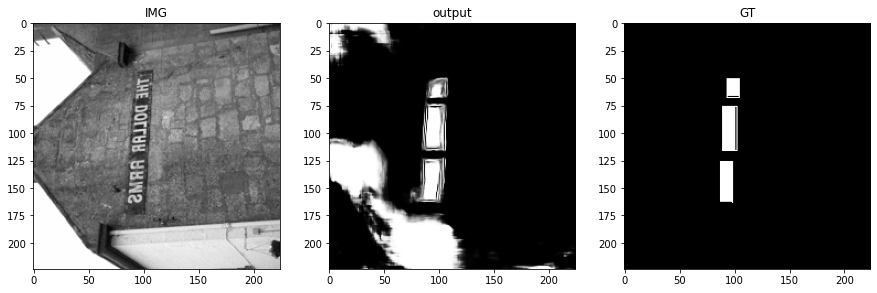

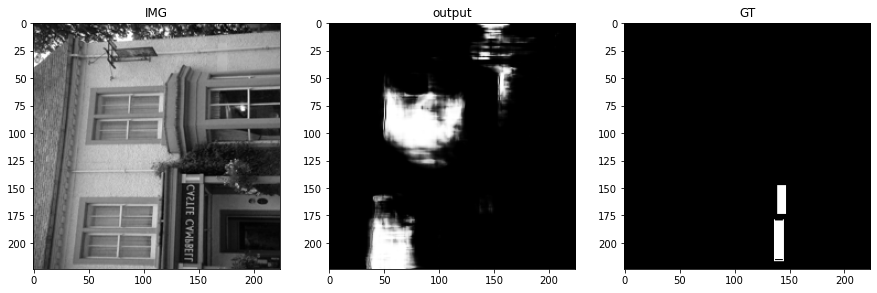

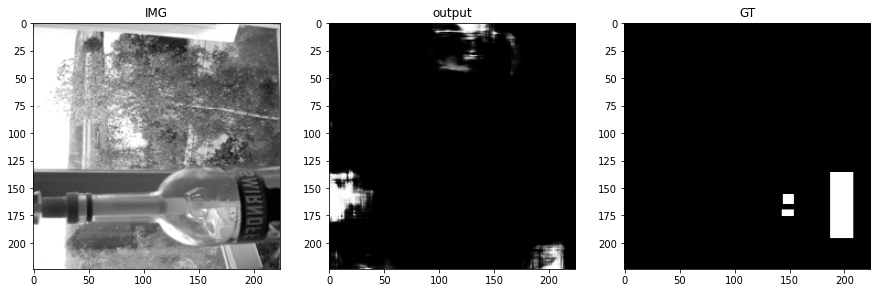

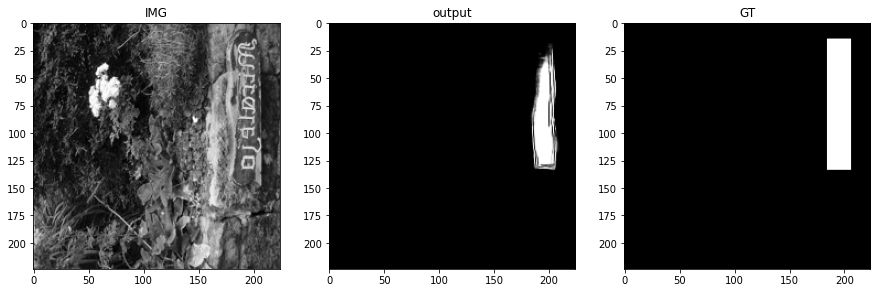

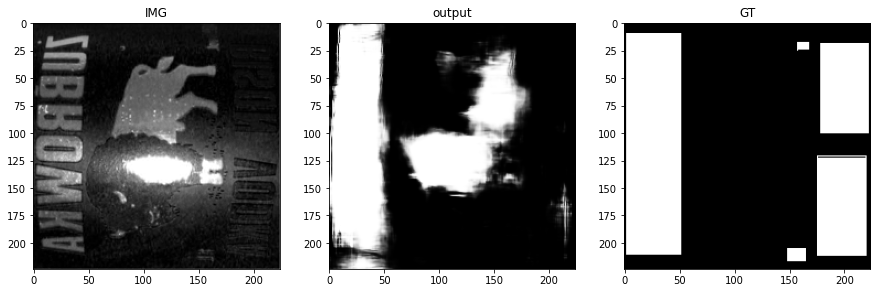

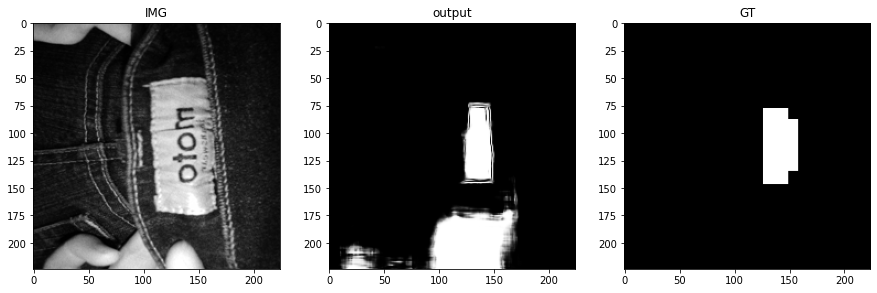

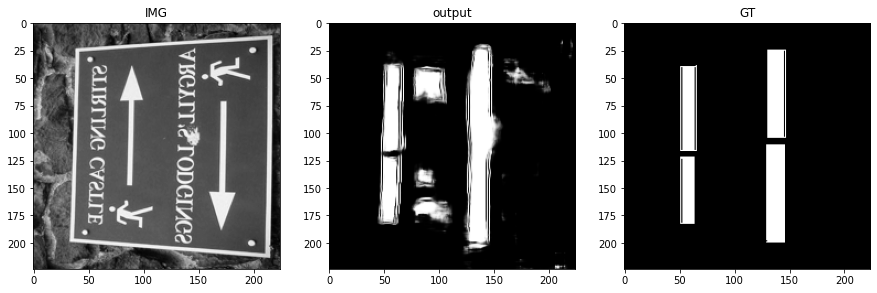

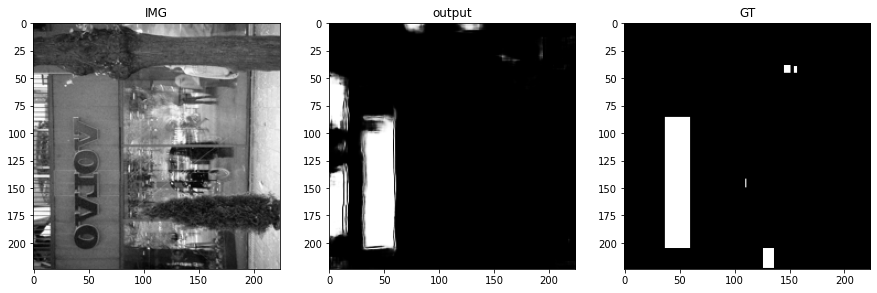

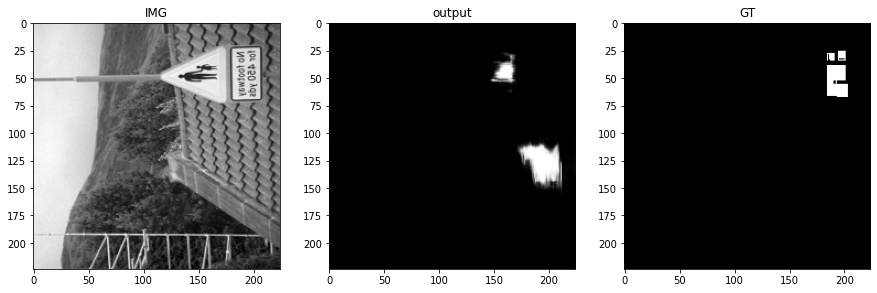

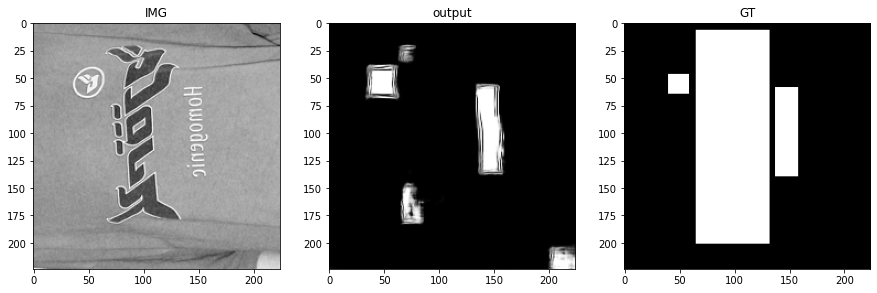

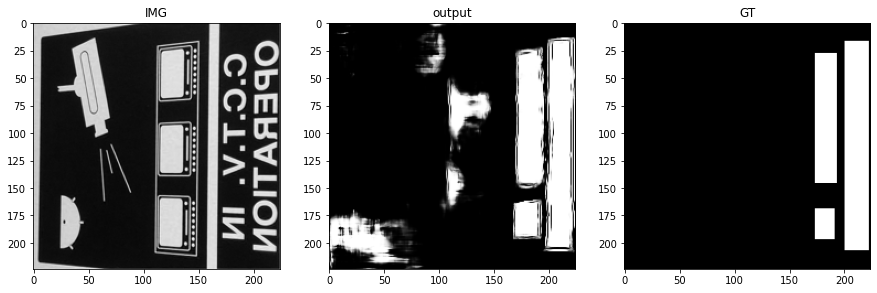

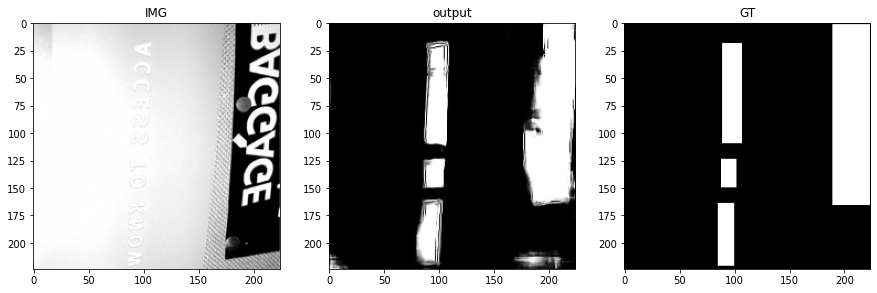

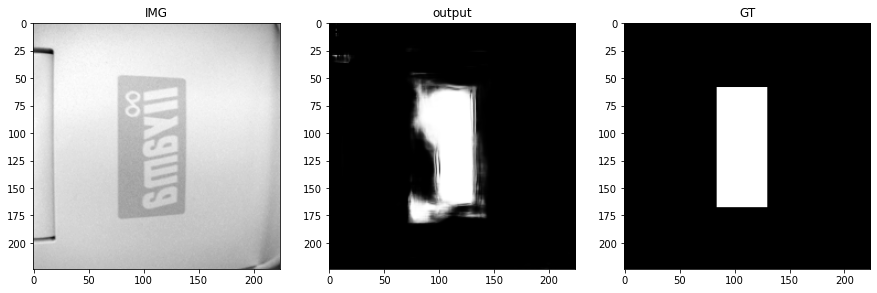

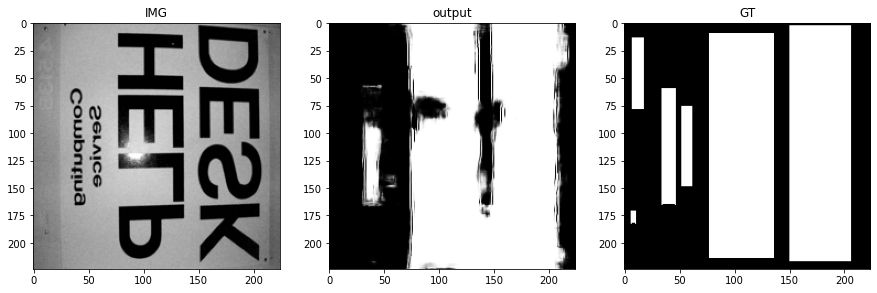

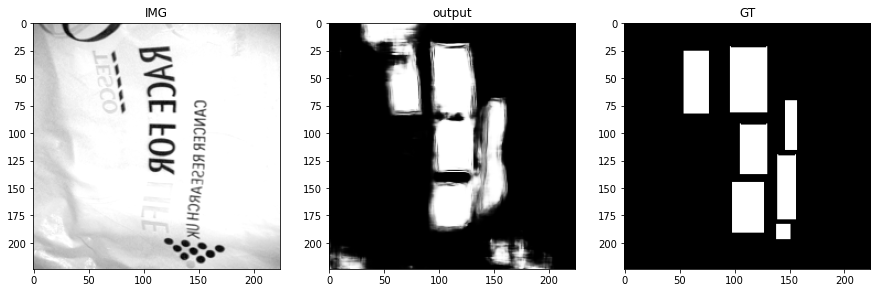

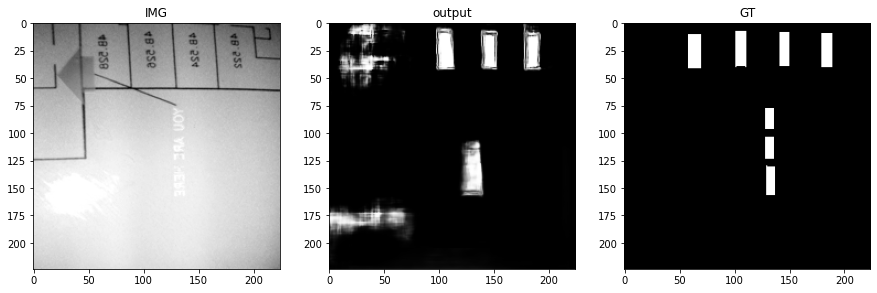

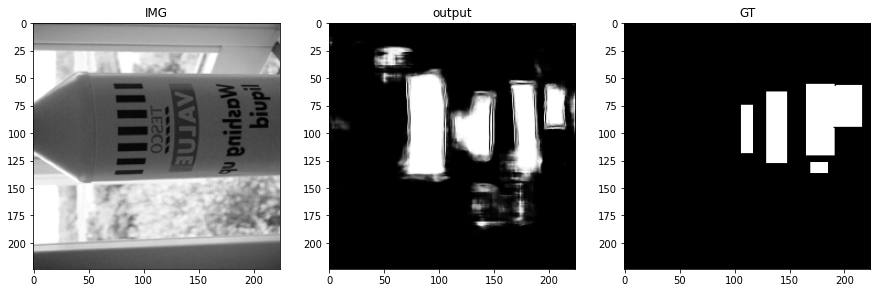

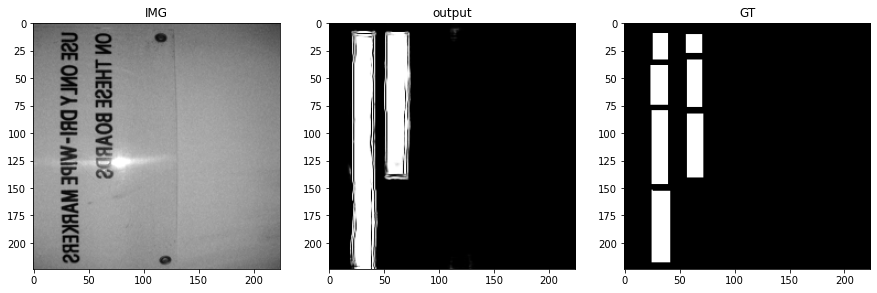

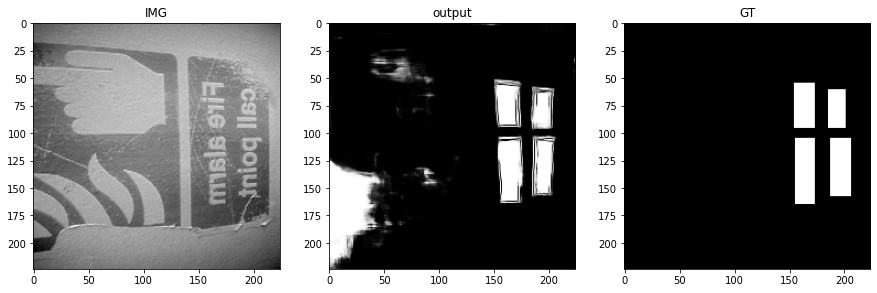

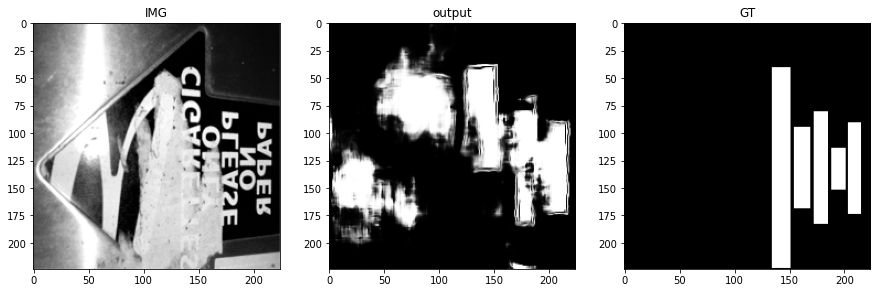

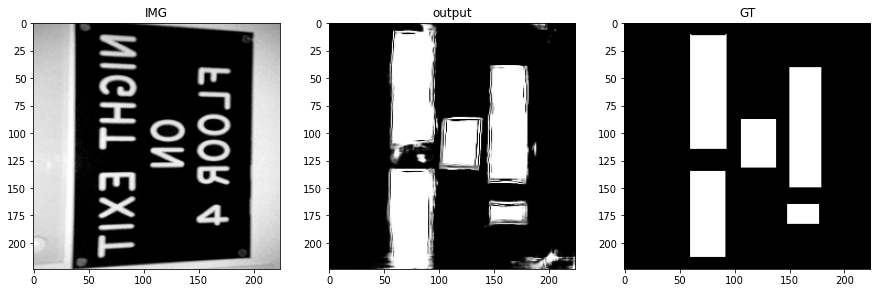

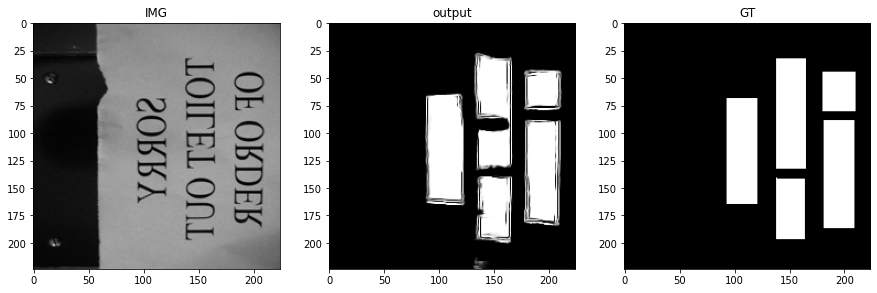

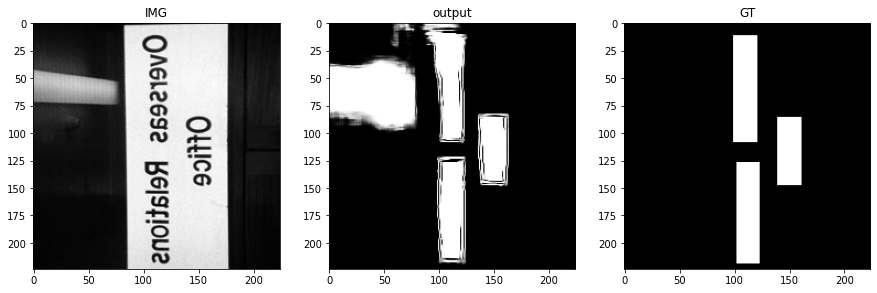

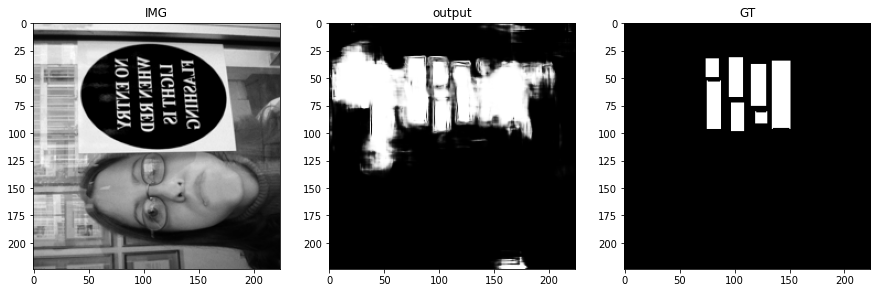

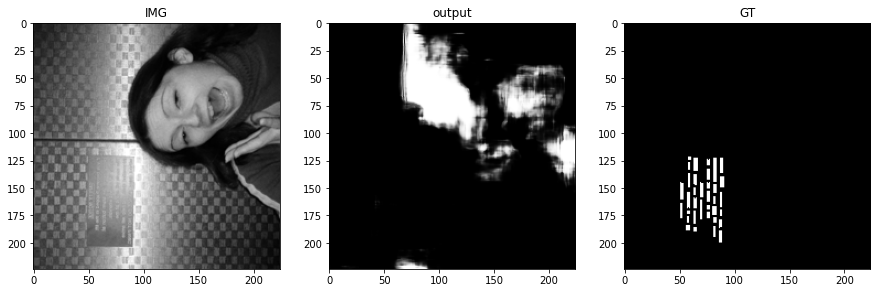

In [0]:
import cv2
i=0
for file in testImgList:
  testImg = TestImages[i]
  testLab = TestLabels[i].numpy()

# Feed-forward 
  segImg = net(Variable(testImg).unsqueeze(0).cuda())
# Applying softmax to get class probabilities
  segImg_np = F.softmax(segImg).data.cpu().squeeze(0).numpy()
  # Displaying segmented output and ground truth
  plt.figure(figsize=(15,15))
  plt.subplot(231)
  #plt.imshow(segImg_np[0,:,:],cmap='gray')
  plt.imshow(testImg[0,:,:],cmap='gray')
  plt.title('IMG')
  #plt.subplot(232)
  #plt.imshow(segImg_np[1,:,:],cmap='gray')
  #plt.title('Channel 2')
  plt.subplot(232)
  plt.imshow(segImg_np[2,:,:],cmap='gray')
  plt.title('output')
  #cv2.2imwrite('/content/drive/My Drive/IC03 Dataset/Segnet_output'+file+'.png',segImg_np[2,:,:]
  #plt.imsave('/content/drive/My Drive/IC03 Dataset/Unet_output'+file+'.png',segImg_np[2,:,:],cmap='gray')


  bg = testLab==0
  #vessel = testLab==1
  mask = testLab==2
  #plt.subplot(234)
  #plt.imshow(bg,cmap='gray')
  #plt.title('Background')
  #plt.subplot(235)
  #plt.imshow(vessel,cmap='gray')
  #plt.title('Vessel')
  plt.subplot(233)
  plt.imshow(mask,cmap='gray')
  plt.title('GT')
  i=i+1
  plt.imsave('/content/drive/My Drive/IC03 Dataset/Unet_output/'+file+'IMG.png',testImg[0,:,:],cmap='gray')
  plt.imsave('/content/drive/My Drive/IC03 Dataset/Unet_output/'+file+'GT.png',mask,cmap='gray')
  plt.imsave('/content/drive/My Drive/IC03 Dataset/Unet_output/'+file+'.png',segImg_np[2,:,:],cmap='gray')

  #cv2.imwrite('/content/drive/My Drive/IC03 Dataset/Segnet_output'+file+'.png',segImg_np[2,:,:]
  #cv2.waitKey(0)
#print(mask)

In [0]:
# Visualizing segmentation on one of the test images
randIdx = np.random.randint(20)
testImg = TestImages[randIdx]
testLab = TestLabels[randIdx].numpy()

# Feed-forward 
segImg = net(Variable(testImg).unsqueeze(0).cuda())
# Applying softmax to get class probabilities
segImg_np = F.softmax(segImg).data.cpu().squeeze(0).numpy()


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


Text(0.5, 1.0, 'Mask')

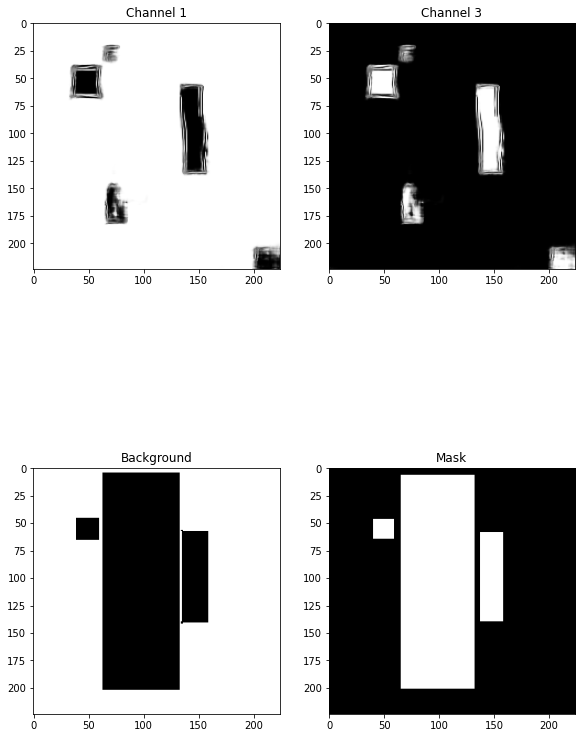

In [0]:
# Displaying segmented output and ground truth
plt.figure(figsize=(15,15))
plt.subplot(231)
plt.imshow(segImg_np[0,:,:],cmap='gray')
plt.title('Channel 1')
#plt.subplot(232)
#plt.imshow(segImg_np[1,:,:],cmap='gray')
#plt.title('Channel 2')
plt.subplot(232)
plt.imshow(segImg_np[2,:,:],cmap='gray')
plt.title('Channel 3')


bg = testLab==0
#vessel = testLab==1
mask = testLab==2
plt.subplot(234)
plt.imshow(bg,cmap='gray')
plt.title('Background')
#plt.subplot(235)
#plt.imshow(vessel,cmap='gray')
#plt.title('Vessel')
plt.subplot(235)
plt.imshow(mask,cmap='gray')
plt.title('Mask')